In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import math

%matplotlib inline

### List of Test Images

In [645]:
imgA_path_list = ['test_img_set6_1.png']
imgB_path_list = ['test_img_set6_2.png']

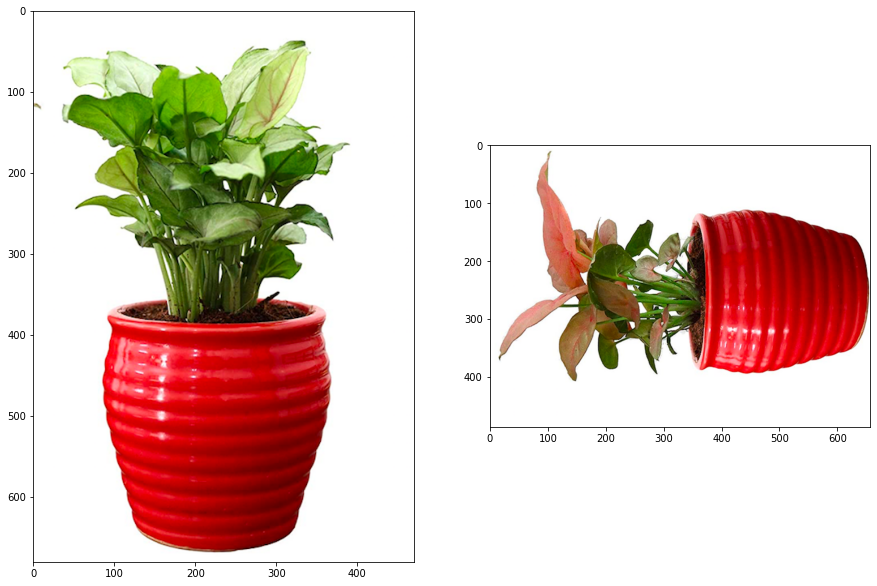

In [646]:
plt.figure(figsize=(15, 12))

plt.subplot(1,2,1)
plt.imshow(Image.open(imgA_path_list[0]))

plt.subplot(1,2,2)
plt.imshow(Image.open(imgB_path_list[0]))

plt.show()

### Utility Functions

In [647]:
def resize_image(img_path, shape_x=728, shape_y=728):
    '''
    Resizing image to a uniform size and return numpy array
    
    Returns:
        numpy array of the image
    '''
    pil_image = Image.open(img_path)
    
    if shape_x == None or shape_y == None:
        shape_x, shape_y = pil_image.size
    
    return np.asarray(pil_image.resize((shape_x, shape_y), Image.ANTIALIAS))

In [648]:
def orb_get_kp_and_descp(img_a_array, img_b_array):
    '''
    Oriented FAST and Rotated BRIEF for Feature Extraction
    returns Keypoints and Descriptions of Keypoints for both images
    '''
    orb = cv2.ORB_create()
    
    a_key_points, a_description = orb.detectAndCompute(img_a_array, None)
    b_key_points, b_description = orb.detectAndCompute(img_b_array, None)
    
    return a_key_points, a_description, b_key_points, b_description

In [649]:
def draw_key_points(img_keypoints, img_array):
    '''
    Draw the Keypoints extracted from images
    Plots a matplotlib plot - returns nothing
    '''
    img_with_keypoints = cv2.drawKeypoints(img_array, 
                                        img_keypoints,
                                        img_array,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10,10))
    plt.imshow(img_with_keypoints)
    plt.show()

In [650]:
def brute_force_matcher(A_description, B_description, do_ratio_test=True, ratio_threshold = 0.75, k_nearest=2):
    '''
    Brute force matcher for all images using Hamming Distance
    
    Option for Lowe's Ratio Test to remove dubious matches (do_ratio_test=True)
    Alternate ratio test logic for k > 2
    
    Returns list of matched features
    '''
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(A_description, B_description, k=k_nearest)
    
    if do_ratio_test and k_nearest == 2:
        # Apply Lowe Ratio Test
        good_matches = []
        scores = []
        for m,n in matches:
            if m.distance < ratio_threshold*n.distance:
                good_matches.append([m])
                scores.append(1/(1+m.distance))
        return good_matches
        
    elif do_ratio_test and k_nearest > 2:
        ### alternate ratio test for k > 2
        good_matches = []
        for m in matches:
            distances = [i.distance for i in m]
            distance_delta = [distances[i+1] - distances[i] for i in range(0, len(distances)-1)]
            top_half_avg_distance = np.mean(distance_delta[0:int(len(distance_delta)/2)])
            bottom_half_avg_distance = np.mean(distance_delta[int(len(distance_delta)/2):len(distance_delta)])
            if top_half_avg_distance * ratio_threshold > bottom_half_avg_distance:
                good_matches.append(m[0])
        
        return good_matches
    
    else:
        matches = bf.match(A_description, B_description)
        return matches

In [651]:
def draw_matches(matches, a_key_points, b_key_points, img_a_array, img_b_array):
    '''
    Draw matches between two images
    Plots a matplotlib plot
    '''
    matches_img = cv2.drawMatches(img_a_array, a_key_points,
                                  img_b_array, b_key_points,
                                  np.asarray(matches).squeeze()[0:50],  
                                  img_b_array, flags=2)

    plt.figure(figsize=(20,15))
    plt.imshow(matches_img)
    plt.show()

# ORB Keypoint Detection and Feature Matching

In [652]:
img_array_1 = resize_image(imgA_path_list[0], None, None)
img_array_2 = resize_image(imgB_path_list[0], None, None)

In [653]:
img_a_array = img_array_1
img_b_array = img_array_2

In [654]:
best_matched_images = []
max_matched_features = []

all_matches = []

a_key_points, a_description, b_key_points, b_description = orb_get_kp_and_descp(img_a_array, img_b_array)

matches = brute_force_matcher(a_description, b_description, do_ratio_test=True, ratio_threshold=0.85, k_nearest=2)

len(matches)

79

### Examples

In [655]:
example_img = imgA_path_list[0]
mapped_img = imgB_path_list[0]

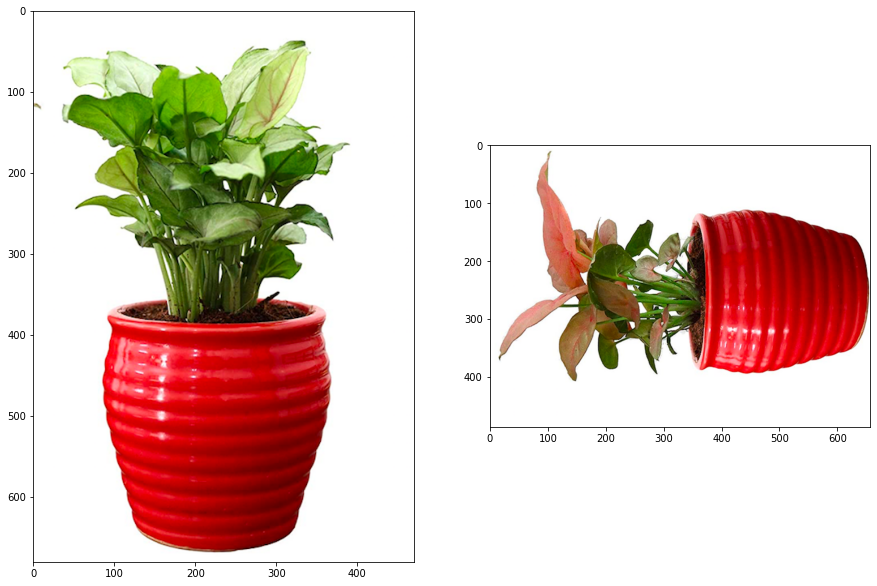

In [656]:
plt.figure(figsize=(15, 12))

plt.subplot(1,2,1)
plt.imshow(Image.open(example_img))

plt.subplot(1,2,2)
plt.imshow(Image.open(mapped_img))

plt.show()

### Intermediate Steps

In [657]:
a_key_points, a_description, b_key_points, b_description = orb_get_kp_and_descp(img_a_array, 
                                                                                img_b_array)

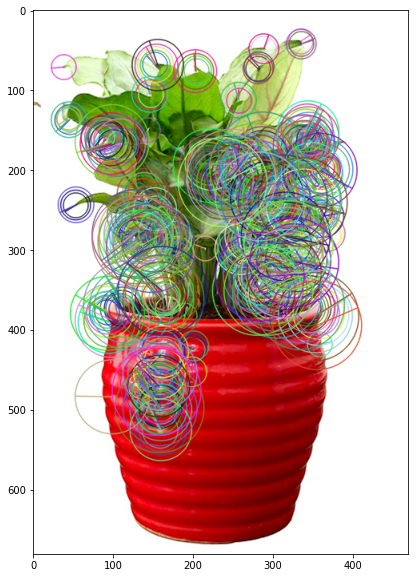

In [658]:
draw_key_points(a_key_points, img_a_array)

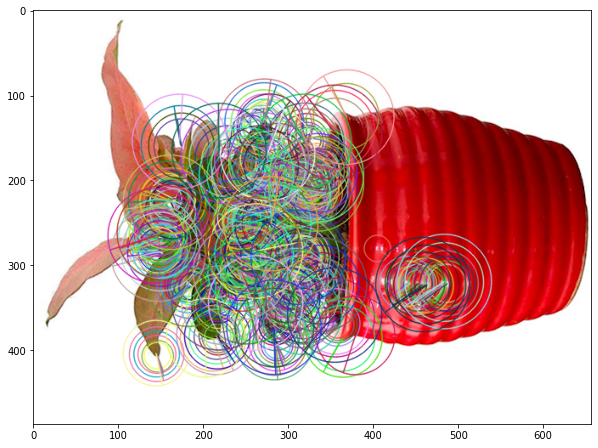

In [659]:
draw_key_points(b_key_points, img_b_array)

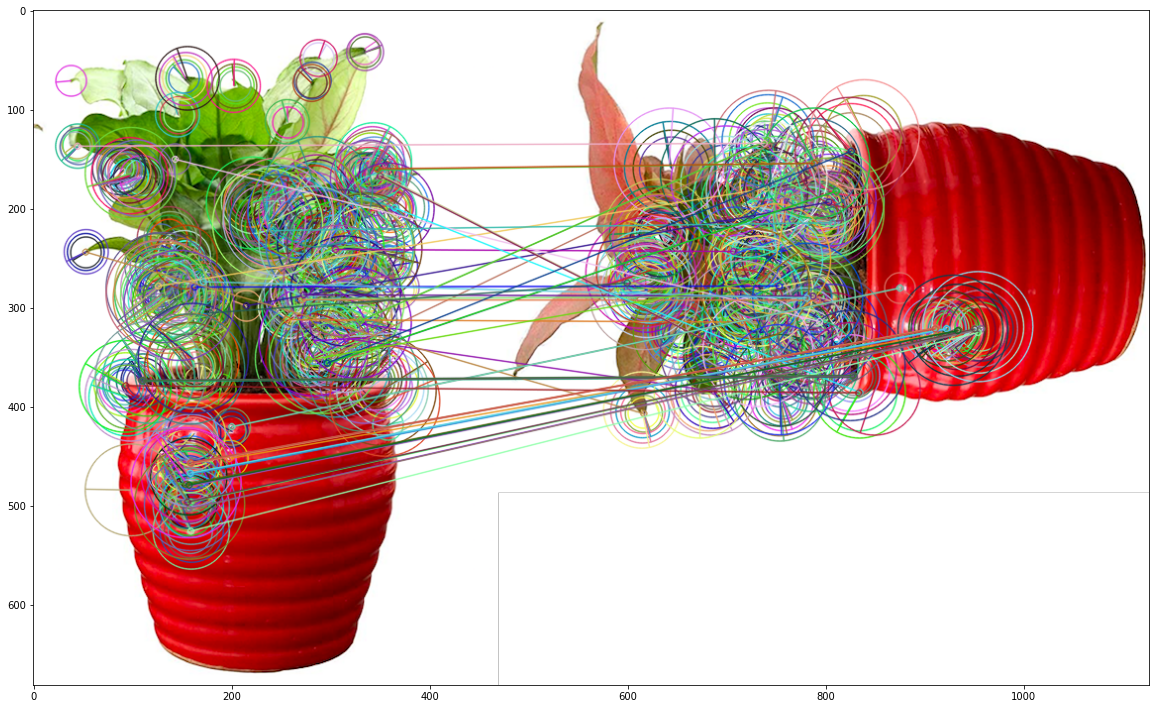

In [660]:
draw_matches(matches, a_key_points, b_key_points, img_a_array, img_b_array)

# Histogram Matching

https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html  
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

In [661]:
def remove_image_background(img_array, mask_range:tuple=(240,255)):
    '''
    helper function for removing background from image
    
    Inputs:
        - img_array: numpy array of image
        - mask_range: tuple, upper and lower bound for image
        
    Returns:
        - image array with background removed
        - mask used to remove background
    '''
    img_array_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    
    ### create mask - will make the range mentioned as 0 and the remaining as 255
    mask = np.zeros(img_array_gray.shape)
    for i in range(0, len(img_array_gray)):
        for j in range(0, len(img_array_gray[i])):
            if mask_range[0] <= img_array_gray[i][j] <= mask_range[1]:
                mask[i][j] = 0
            else:
                mask[i][j] = 255
    
    ### removes internal and external noise
    kernel = np.ones((1,1), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    ### smoothing using gaussian blur
    mask = cv2.GaussianBlur(mask, (0,0), sigmaX=1, sigmaY=1, borderType = cv2.BORDER_DEFAULT)

    ### put mask into alpha channel
    no_background_img_array = img_array.copy()
    no_background_img_array = cv2.cvtColor(no_background_img_array, cv2.COLOR_BGR2BGRA)
    no_background_img_array[:, :, 3] = mask
    
    return no_background_img_array, mask, img_array_gray

In [662]:
img_array_1 = resize_image(imgA_path_list[0], 728, 728)
img_array_2 = resize_image(imgB_path_list[0], 728, 728)

img_a_array = img_array_1
img_b_array = img_array_2

img_a_array_rgb = cv2.cvtColor(img_a_array, cv2.COLOR_BGR2RGB)
img_b_array_rgb = cv2.cvtColor(img_b_array, cv2.COLOR_BGR2RGB)

In [663]:
img_a_no_background, mask_a, img_a_array_gray = remove_image_background(img_a_array, (240,255))
img_b_no_background, mask_b, img_b_array_gray = remove_image_background(img_b_array, (240,255))

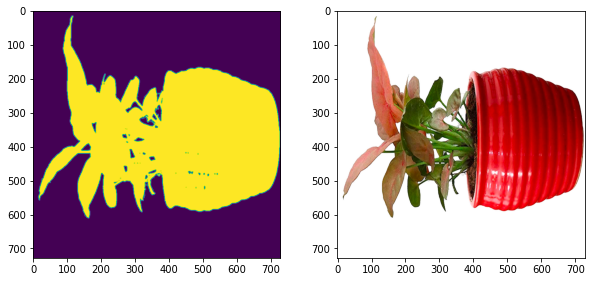

In [664]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(mask_b)

plt.subplot(2,2,2)
plt.imshow(img_b_no_background)

#cv2.imwrite('no_background_image.png', result)

In [665]:
def histogram_matching(img_a_array:np.array, img_b_array:np.array,
                       mask_a_array:np.array=None, mask_b_array:np.array=None,
                       plot:bool=False):
    '''
    generating image histogram and cacluating correlation and overlap
    
    Inputs:
        - img_a_array: numpy array of image a
        - img_b_array: numpy array of image b
        - mask_a_array: mask of image a overlapping only the object
        - mask_b_array: mask of image b overlapping only the object
        - plot: boolean value to determine whether to plot results or not
        
    Returns:
        - overlap score, correlation score
    '''
    
    split_img_a = cv2.split(img_a_array)
    split_img_b = cv2.split(img_b_array)

    print([i.shape for i in split_img_a])
    
    histogram_overlap_scores = []
    historgram_correlation_scores = []

    if plot:
        plt.figure(figsize=(15,10))
        
    for channel_a, channel_b, color in zip(split_img_a, split_img_b, ['r', 'g', 'b']):
        print(channel_a.shape)
        #print(mask_a_array.shape)
        if mask_a_array is None or mask_b_array is None:
            hist_a = cv2.calcHist([channel_a], [0], None, [32], [0,256])
            hist_b = cv2.calcHist([channel_b], [0], None, [32], [0,256])
        else:    
            hist_a = cv2.calcHist([channel_a], [0], mask_a_array.astype(np.uint8), [32], [0,256])
            hist_b = cv2.calcHist([channel_b], [0], mask_b_array.astype(np.uint8), [32], [0,256])

        overlap_score = cv2.compareHist(hist_a, hist_b, method=cv2.HISTCMP_BHATTACHARYYA)
        histogram_overlap_scores.append(1 - overlap_score)

        correlation_score = cv2.compareHist(hist_a, hist_b, method=cv2.HISTCMP_CORREL)
        historgram_correlation_scores.append(correlation_score)

        if plot:
            plt.subplot(2,1,1)
            plt.plot(hist_a, color=color)

            plt.subplot(2,1,2)
            plt.plot(hist_b, color=color)

    return np.mean(histogram_overlap_scores), np.mean(historgram_correlation_scores)

[(728, 728), (728, 728), (728, 728), (728, 728)]
(728, 728)
(728, 728)
(728, 728)


(0.8810105705799532, 0.9821609484876181)

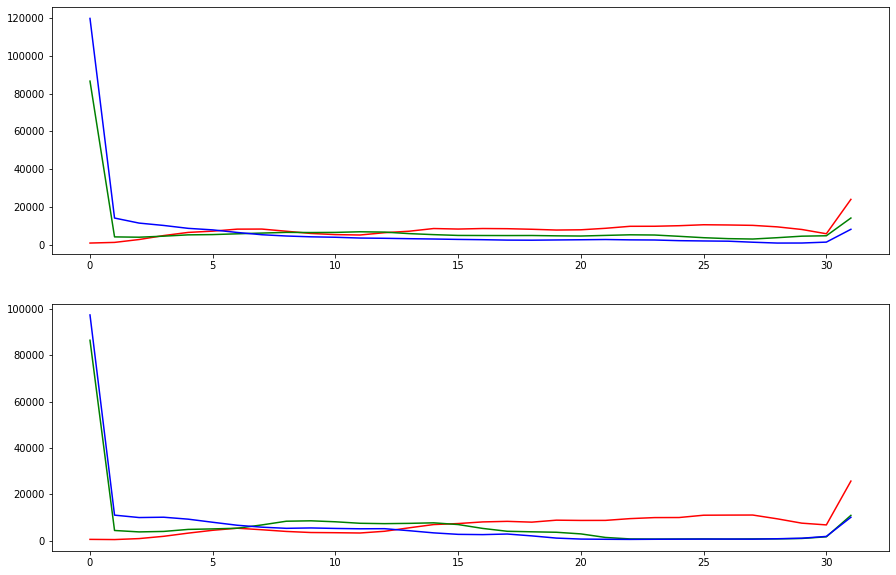

In [666]:
histogram_matching(img_a_no_background, img_b_no_background, mask_a, mask_b, True)